import libraries

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.optimize import curve_fit
import sympy as sym

#import scipy as sc
#import pandas as pd

import numpy.random as rndm
from numpy.random import uniform as UNFM
#from numpy.random import randint 
#from matplotlib.animation import FuncAnimation

import time

import scienceplots
plt.style.use(['science','notebook','grid'])


transform direction vector after scattering
------------------------

transform between cartesian and spherical CS

In [ ]:
"""
Comments will follow...
"""

def spherical_to_cartesian(theta, phi):
    x = np.cos(theta)
    y = np.sin(theta) * np.cos(phi)
    z = np.sin(theta) * np.sin(phi)
    return np.array([x, y, z])

# this one for now is not needed anywhere!
def cartesian_to_spherical(u):
    u = u / np.linalg.norm(u)
    theta = np.arccos(u[0])  # because x = cos(theta)
    phi = np.arctan2(u[2], u[1])  # y = sin(theta) cos(phi), z = sin(theta) sin(phi)
    return theta, phi


In [168]:
def NewDirectionUnitVector(u_old, theta_sc, phi_sc):
    """
    Apply scattering to the old direction vector u_old using the scattering angles theta_sc and phi_sc.
    
    Parameters:
    u_old : np.ndarray
        Original direction (unit vector, shape (3,))
    theta_sc : float
        Scattering polar angle (radians)
    phi_sc : float
        Scattering azimuthal angle (radians)
    
    Returns:
    u_new : np.ndarray
        New direction (unit vector, shape (3,))
    """
    u_old = u_old / np.linalg.norm(u_old)  # Ensure u_old is normalized

    # New direction in local scattering frame
    u_sc_local = spherical_to_cartesian(theta_sc, phi_sc) 
    
    if np.allclose(u_old, [1, 0, 0]):
        return u_sc_local / np.linalg.norm(u_sc_local)

    # if u_old is not close to [1,0,0] - normal rotation procedure
    ref_vec = np.array([1, 0, 0])
    # find 2 other orthogonal vectors to u_old
    v = np.cross(ref_vec, u_old)
    v /= np.linalg.norm(v)  # Normalize v
    w = np.cross(u_old, v)  # v is orthogonal to both u_old and u
    w /= np.linalg.norm(w)  # Normalize v
    # find the rotation matrix
    R = np.column_stack((u_old, v, w))  # Rotation matrix with columns as local frame vectors
    
    # Apply the rotation to the scattering vector
    u_new = R @ u_sc_local  # Rotate the scattering vector to the global frame
    u_new /= np.linalg.norm(u_new)  # Ensure the new direction is a unit vector
    return u_new


# Example usage
u_old = np.array([1, 0.1, 3])  # x-direction
print("u_old ={}".format(u_old / np.linalg.norm(u_old)))
theta_sc = -np.pi / 4         # 45 degrees
phi_sc = np.pi / 3           # 90 degrees
u_new = NewDirectionUnitVector(u_old, theta_sc, phi_sc)
print("u_new1 =", u_new)

## needs extra testing!

u_old =[0.31606977 0.03160698 0.94820931]
u_new1 = [-0.35748467  0.38215481  0.85215164]


Compton Scattering generate with help of Geant4 method - https://geant4.web.cern.ch/documentation/pipelines/master/prm_html/PhysicsReferenceManual/electromagnetic/gamma_incident/compton/compton.html

-----------------------------

using method called combined composition and rejection MC method for RNG for K-N Compton energy PDF !!!
---------------------------------


In [169]:
def ComptonEnergyGenerator(E):
    """
    E - energy of the incident photon (MeV)
    E_scattered - energy of the scattered photon (MeV)
    """
    # Define the mass of the electron in MeV/c^2
    m_e = 0.511  # MeV/c^2
    # alpha = E/m_e  # Calculate the alpha parameter for Compton scattering
    alpha = E / m_e 
    # Es = Egamma after scattering; eps = Es/E; eps_min = minimal energy of scattered photon
    eps_min = 1 / (1 + 2 * alpha)  # Minimum energy of the scattered photon
    # eps_max = 1
    beta1 = - np.log(eps_min)
    beta2 = 0.5 * (1 -eps_min**2)

    # Loop to find the scattered energy  - using combined composition and rejection MC method for RNG for K-N Compton energy PDF
    while True:
        # finding the proposed energy of the scattered photon
        r1,r2,r3 = np.random.uniform(0, 1, 3)  # Generate random numbers for the scattering angle
        if r1 < beta1 / (beta1 + beta2):
            ### here, total chaos, i dont know what to use??
            eps_prop = eps_min**r2  # geant4 page
            #eps_prop = eps_min * np.exp(beta2*r2) # Studen 2024
            #eps_prop = eps_min * np.exp((beta1+beta2)*r2-beta1)  # Studen 2020
        else:
            eps_prop = np.sqrt(eps_min**2 + (1- eps_min**2) * r2) # Geant4, Stuedn 2024
            #eps = np.sqrt(eps_min**2 + 2*r2*(beta1+beta2))  # Studen 2020
        # compare g(eps) with r3
        t = (1 - eps_prop) / alpha/ eps_prop
        g_eps = 1 - eps_prop *t*(2-t)/(1+eps_prop**2)
        # accepting the proposed energy of the scattered photon under the condition
        if g_eps > r3:
            eps = eps_prop
            #print("eps =", eps)
            break

    # Calculate the energy, scattering angles and post-interaction direction of the scattered photon
    E_scattered = E * eps  # MeV
    theta_cs = np.arccos(1 - 1/alpha*(1/eps-1)) # Scattering angle in radians
    
    return eps,theta_cs
    # return {
    #     'E_scattered': E_scattered,
    #     'E_electron': E - E_scattered,  # Energy of the recoiled electron
    #     'theta_cs': theta_cs,
    # }

# test the ComptonEnergyGenerator function
E = 1.0  # MeV
eps, theta_cs = ComptonEnergyGenerator(E)
print("eps =", eps)
print("theta_cs =", theta_cs)


eps = 0.8578135132644406
theta_cs = 0.4145456171537159


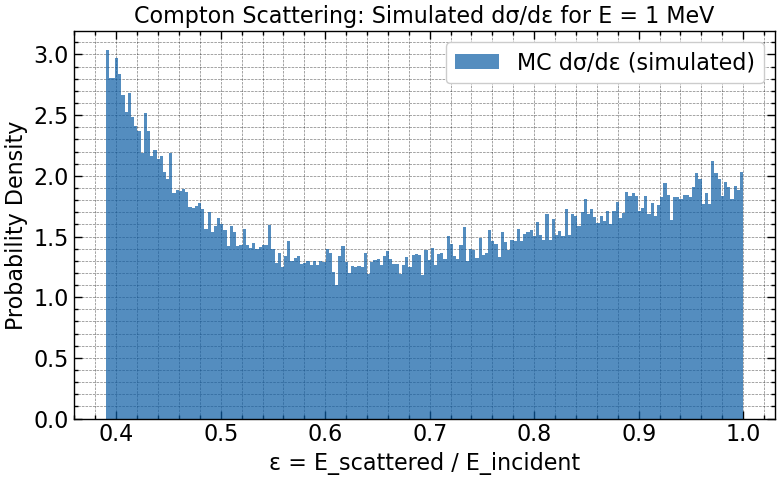

C:\Users\Admin\AppData\Local\Temp\ipykernel_3732\5347191.py:28: RuntimeWarning: invalid value encountered in arccos
  th = np.arccos(1 - 1/alpha*(1/eps-1))  # Scattering angle in radians


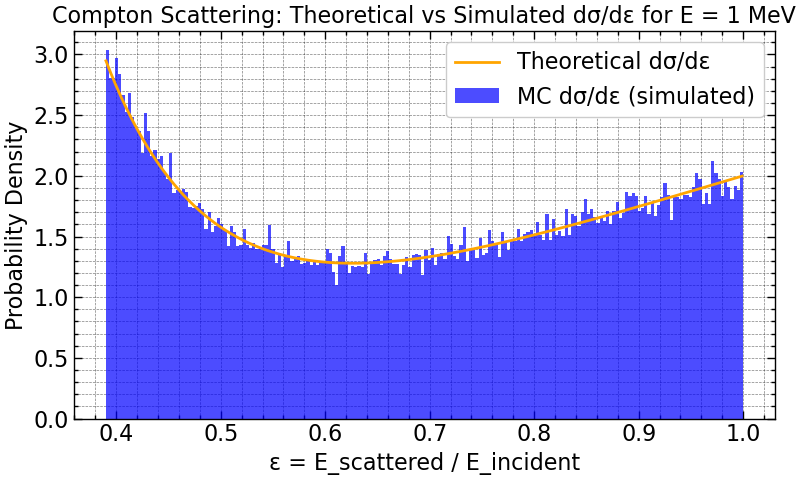

In [170]:
# Test the ComptonEnergyGenerator for E = 1 MeV
E = 0.4  # MeV
Ncs = 10**5  # Number of events

eps_samples = []
theta_cs_samples = []
for _ in range(Ncs):
    eps, th = ComptonEnergyGenerator(E)
    eps_samples.append(eps)
    theta_cs_samples.append(th)

eps_samples = np.array(eps_samples)
theta_cs_samples = np.array(theta_cs_samples)
E_scattered_samples = eps_samples * E

# Plot histogram of eps (normalized to probability density)
plt.figure(figsize=(8,5))
plt.hist(eps_samples, bins=200, density=True, alpha=0.7, label='MC dσ/dε (simulated)')
plt.xlabel('ε = E_scattered / E_incident')
plt.ylabel('Probability Density')
plt.title('Compton Scattering: Simulated dσ/dε for E = 1 MeV')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

def dsdeps(eps,alpha=1.0):
    th = np.arccos(1 - 1/alpha*(1/eps-1))  # Scattering angle in radians
    t = (1 - eps) / alpha / eps
    g_eps = 1 - eps * t * (2 - t) / (1 + eps**2)

    return 1/eps + eps - np.sin(th)**2

# Plot the theoretical dσ/dε for Compton scattering
eps_values = np.linspace(0.01, 0.999, 1000)  # Avoid division by zero
F = 1
dsdeps_values = dsdeps(eps_values,alpha=E / 0.511) * F # E = 1 MeV, m_e = 0.511 MeV/c^2
plt.figure(figsize=(8,5))
plt.plot(eps_values, dsdeps_values, label='Theoretical dσ/dε', color='orange')
plt.hist(eps_samples, bins=200, density=True, alpha=0.7, label='MC dσ/dε (simulated)', color='blue')
plt.xlabel('ε = E_scattered / E_incident')
plt.ylabel('Probability Density')
plt.title('Compton Scattering: Theoretical vs Simulated dσ/dε for E = 1 MeV')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [171]:
"""
Consider Compton Scattering Interaction
Compton kinametics is a one parameter function that describes the energy and angle of the scattered photon in realtion 
to the incident photon energy and the pre-interaction photon direction.

"""


def ComptonScatteringInteraction(E, u_particle):
    """
    E - energy of the incident photon (MeV)
    u_particle - direction of the incident photon (unit vector)
    
    Returns:
    E_scattered - energy of the scattered photon (MeV)
    u_scattered - direction of the scattered photon (unit vector)
    """
    # draw eps and th_cs
    eps, theta_cs = ComptonEnergyGenerator(E)  # Get the energy fraction and scattering angle

    # Calculate the energy, scattering angles and post-interaction direction of the scattered photon
    E_scattered = E * eps  # MeV
    # draw phi_cs
    phi_cs = 2*np.pi * np.random.uniform(0, 1)  # Azimuthal angle in radians
    
    # Calculate the direction of the scattered photon
    u_new = NewDirectionUnitVector(u_particle, theta_cs, phi_cs)

    return {
        'E_initial': E,
        'E_scattered': E_scattered,
        'E_electron': E - E_scattered,  # Energy of the recoiled electron
        'u_new': u_new,
        'theta_cs': theta_cs,
        'phi_cs': phi_cs
    }
    
# Example usage
E = 1.0  # MeV
u_particle = np.array([1, 0, 0])  # Initial direction of the photon (unit vector)
result = ComptonScatteringInteraction(E, u_particle)
print("E_initial =", result['E_initial'])
print("E_scattered =", result['E_scattered'])
print("E_electron =", result['E_electron'])
print("u_new =", result['u_new'])
print("theta_cs =", result['theta_cs'])
print("phi_cs =", result['phi_cs'])




E_initial = 1.0
E_scattered = 0.6521319148435349
E_electron = 0.34786808515646506
u_new = [ 0.72741621 -0.01556253 -0.68602002]
theta_cs = 0.7562473150219385
phi_cs = 4.689707630924338


interpolation for point-to-point values list

In [172]:
def interpolate_lac(energy_points, ac_values, energy_query):
    """
    Linearly interpolate LAC for a given energy_query.
    energy_points: array of known energies (MeV)
    ac_values: array of LAC/MAC values at those energies
    energy_query: scalar or array of energies to interpolate at
    Returns: interpolated LAC value(s)
    """
    return np.interp(energy_query, energy_points, ac_values)



# Example usage of the interpolate_lac function for MAC values
energy_query = 0.025  # Example energy in MeV
mac_cs_interpolated = interpolate_lac(energy_lead, mac_incoherent_lead, energy_query) 
mac_pe_interpolated = interpolate_lac(energy_lead, mac_photoelectric_lead, energy_query)
mac_pp_interpolated = interpolate_lac(energy_lead, mac_pair_production_nuclear_lead + mac_pair_production_electron_lead, energy_query)

print(f"Interpolated MAC values at {energy_query} MeV:")
print(f"Compton Scattering (CS): {mac_cs_interpolated:.4f} cm^2/g")
print(f"Photoelectric Effect (PE): {mac_pe_interpolated:.4f} cm^2/g")
print(f"Pair Production (PP): {mac_pp_interpolated:.4f} cm^2/g")



Interpolated MAC values at 0.025 MeV:
Compton Scattering (CS): 0.0756 cm^2/g
Photoelectric Effect (PE): 56.4150 cm^2/g
Pair Production (PP): 0.0000 cm^2/g


Find path lenght to exit in cuboid

In [ ]:
""" 
For the start find the path length of particle to the plane
Assumptions and characteristics:
- 3D environment 
particle is assumed to be traveling in a straight line
- particle is at location r_particle, its direction is given by unit vector u_particle
- plane is defined by point r_plane and normal vector n_plane
- the plane is infinite in size, so we can ignore the boundaries
"""

def find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane):
    """
    Find the path length of a particle to the plane.
    
    Parameters:
    r_particle: np.array, position of the particle (3D vector)
    u_particle: np.array, unit vector in the direction of the particle's motion (3D vector)
    r_plane: np.array, point on the plane (3D vector)
    n_plane: np.array, normal vector of the plane (3D vector) - SHOULD BE DIRECTED OUTWARD FROM THE PLANE (or from the 
    inside of the cuboud/rectangle)!!  -- else the code wont work properly!
    
    Returns:
    path_length: float, distance from the particle to the plane
    """
    # Ensure u_particle is a unit vector
    u_particle = u_particle / np.linalg.norm(u_particle)
    n_plane = n_plane / np.linalg.norm(n_plane)
    
    # relative direction of the particle with respect to the plane
    relative_direction_scaling_factor = np.dot(u_particle, n_plane)
    
    # a) if the particle is moving towards the plane, relative_direction_scaling_factor > 0
    if relative_direction_scaling_factor > 0:
        d = np.dot(n_plane, r_particle - r_plane)    
        path_length = abs(d) / relative_direction_scaling_factor
        return path_length
    
    # b) if the particle is moving away from the plane (or parallel to it), relative_direction_scaling_factor < 0
    else:
        return np.inf
       
     

# Example usage
r_particle = np.array([1.0, 0.0, 0.0])  # Particle position
u_particle = np.array([1, 0.0, 0.0])  # Particle direction (unit vector)
r_plane = np.array([0.0, -3.0, 0.0])  # Point on the plane
n_plane = np.array([0.0, -1.0, 0.0])  # Normal vector of the plane
path_length = find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane)
print(f"Path length from particle to plane: {path_length:.4f} units")

## test this a bit, at least in 2d (x,y) - and check if it works!
### SEEMS LIKE IT WOKRS SUPER!!


Path length from particle to plane: inf units


next step: find the BoxPathLeggth - inside cuboid/rectangle

In [195]:
def BoxPathLength3D(r_particle, u_particle, cuboid_dimensions):
    """
    Find the path length to the exit of a cuboid/rectangle.
    
    Parameters:
    r_particle: np.array, position of the particle (3D vector)
    u_particle: np.array, unit vector in the direction of the particle's motion (3D vector)
    cuboid_dimensions: tuple, dimensions of the cuboid (length, width, height)
    face_normals: list of np.array, normal vectors of the cuboid faces (3D vectors) - should be directed outward from the cuboid
    
    Returns:
    path_length: float, distance to the exit of the cuboid
    """

    a, b, c = cuboid_dimensions  # unpack dimensions of the cuboid

    # 6 planes: 1-6 or F (forward), B (backward), L (left), R (right), T (top), D (down)
    # Define r_plane for each face of the cuboid
    rF = np.array([a/2,0,0]) # Front face
    rB = np.array([-a/2,0,0]) # Back face
    rL = np.array([0,b/2,0]) # Left face
    rR = np.array([0,-b/2,0]) # Right face
    rT = np.array([0,0,c/2]) # Top face
    rD = np.array([0,0,-c/2]) # Down face
    r_list = [rF, rB, rL, rR, rT, rD]  # List of points on the cuboid faces 

    # Define the face normals for the cuboid
    nF = np.array([1,0,0])
    nB = np.array([-1,0,0])
    nL = np.array([0,1,0])
    nR = np.array([0,-1,0])
    nT = np.array([0,0,1])
    nD = np.array([0,0,-1])
    n_list = [nF, nB, nL, nR, nT, nD]  # List of normal vectors for the cuboid faces
    
    # Initialize minimum path length to infinity
    min_path_length = np.inf
    exit_plane_index = -1  # Index of the exit plane (face) with the minimum path length

    # Iterate over each face normal
    for plane_index in range(6):
        r_plane, n_plane = r_list[plane_index], n_list[plane_index]  # Get the point on the face and its normal vector        
        # Calculate path length to this face
        path_length_to_plane = find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane)
        if path_length_to_plane < min_path_length:
            min_path_length = path_length_to_plane
            exit_plane_index = plane_index  # Update the exit plane index


    return min_path_length, exit_plane_index

# Example usage
r_particle = np.array([1.9, 1.9, 0.0])  # Particle position
u_particle = np.array([-1, -1., -0.0])  # Particle direction (unit vector)
cuboid_dimensions = (4.0, 4.0, 4.0) # Dimensions of the cuboid (length, width, height)
print(f"Particle position: {r_particle}, direction: {u_particle}")
print(f"Cuboid dimensions: {cuboid_dimensions} (length, width, height)")
# path_length = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)    
# print(f"\nPath length to the exit of the cuboid: {path_length:.4f} units")
min_path_length, exit_plane_index = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)
print(f"\nMinimum path length to the exit of the cuboid: {min_path_length:.4f} units")
print(f"Exit plane index: {exit_plane_index} (0: Front, 1: Back, 2: Left, 3: Right, 4: Top, 5: Down)")



Particle position: [1.9 1.9 0. ], direction: [-1. -1. -0.]
Cuboid dimensions: (4.0, 4.0, 4.0) (length, width, height)

Minimum path length to the exit of the cuboid: 5.5154 units
Exit plane index: 1 (0: Front, 1: Back, 2: Left, 3: Right, 4: Top, 5: Down)


free path for neutral particles with multiple possible interaction types

In [146]:
def FreePathLowEnergy(E,energy_list,lac_cs,lac_pe):
    """
    Calculate the free path length for low energy photons in a medium.
    Low energy means that the energy is below the threshold for pair production.
    Other interacitons are neglected (Rayleigh scattering - not so important, also hard to find data for scattering angles, 
    nuclear interactions are very rare at those energies, etc.)
    This function uses the linear attenuation coefficients for Compton scattering and photoelectric effect
    to generate the free path length for a photon of energy E.
    The free path length is calculated as the minimum of the free path lengths for Compton scattering and photoelectric effect.
    
    Parameters:
    E : Energy of the photon (MeV)
    energy_liat : List of energies (MeV) for which the lac values are known
    lac_list : List of linear attenuation coefficients (cm^-1) for Compton scattering and photoelectric effect

    Returns:
    Free path length in cm.
    """
    
    # find the linear attenuation coefficient for Compton scattering and photoelectric effect at given photon energy
    lac_cs = interpolate_lac(energy_list, lac_cs, E)  # Compton scattering
    lac_pe = interpolate_lac(energy_list, lac_pe, E)  # Photoelectric effect

    # gerenrate free paths for Compton scattering and photoelectric effect
    u1, u2 = np.random.uniform(0, 1, 2)  # Generate two random numbers for the free path calculation
    s_cs = - np.log(u1) / lac_cs  # Compton scattering free path length
    s_pe = - np.log(u2) / lac_pe  # Photoelectric effect free path length

    # take lower number
    free_path_length = min(s_cs,s_pe)
    
    return free_path_length

# Example usage
E = 0.1  # MeV
free_path_length = FreePathLowEnergy(E,energy_lead, lac_cs_lead,lac_pe_lead)
print(f"Free path length for low energy photon (E = {E} MeV): {free_path_length:.4f} cm")



Free path length for low energy photon (E = 0.1 MeV): 0.0079 cm


In [310]:
def FreePathWithPP(E,energy_list,lac_cs,lac_pe, lac_pp):
    """
    Calculate the free path length for photons, including pair production interactions.
    Similar to FreePathLowEnergy, but also considers pair production interactions.

    Parameters:
    E : Energy of the photon (MeV)
    energy_lead : List of energies (MeV) for which the lac values are known
    lac_list : List of linear attenuation coefficients (cm^-1) for CS, PE, and PP

    Returns:
    Free path length in cm.
    """
    
    # find lac for Cs, PE, PP
    lac_cs = interpolate_lac(energy_list, lac_cs, E)  # Compton scattering
    lac_pe = interpolate_lac(energy_list, lac_pe, E)  # Photoelectric effect
    #lac_pp = interpolate_lac(energy_list, lac_pp, E)  # Pair production

    # gerenrate free paths for Compton scattering and photoelectric effect
    u1, u2, u3 = np.random.uniform(0, 1, 3)  # Generate two random numbers for the free path calculation
    s_cs = - np.log(u1) / lac_cs  # Compton scattering free path length
    s_pe = - np.log(u2) / lac_pe  # Photoelectric effect free path length
    #s_pp = - np.log(u3) / lac_pp  # Pair production free path length
    
    # separate procedure for PP
    if E > 1.022:
        lac_pp = interpolate_lac(energy_list, lac_pp, E)
        s_pp = - np.log(u3) / lac_pp
    else:
        s_pp = np.inf  # If energy is below pair production threshold, set free path to infinity

    # take lower number
    free_path_length = min(s_cs,s_pe,s_pp)
    # also determine the interaction type
    if free_path_length == s_cs:
        interaction_type = 'compton'
    elif free_path_length == s_pe:
        interaction_type = 'phot'
    elif free_path_length == s_pp:
        interaction_type = 'pair'
    
    return free_path_length, interaction_type

# Example usage
E = 3.5  # MeV
free_path_length, interaction_type = FreePathWithPP(E, energy_lead, lac_cs_lead, lac_pe_lead, lac_pp_lead)
print(f"Free path length for photon (E = {E} MeV): {free_path_length:.4f} cm")
print(f"Interaction type: {interaction_type}")


Free path length for photon (E = 3.5 MeV): 6.8524 cm
Interaction type: compton


pair production: isotropic point source direction unit vector


In [311]:
def IsotropicPointSourceDirectionVector():
    # Isotropic: uniform in cos(theta) and phi
    phi = np.random.uniform(0, 2 * np.pi)         # azimuthal angle
    #costheta = np.random.uniform(-1, 1)           # uniform in cos(theta)
    #theta = np.arccos(costheta) 
    theta = np.arccos(np.random.uniform(-1.1))               

    # Convert spherical to Cartesian coordinates
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    u = np.array([x, y, z])
    
    return u

def PairProductionGammasDirections():
    """
    Generate isotropic gamma directions for pair production.
    First gamma direction is isotropic, generated by spherical coordinates: theta and phi angles.
    Second gamma direction is direct opposite to the first gamma direction.
    
    Returns:
        Direction vectors of the two gammas (unit vectors).
    """
    # Isotropic: uniform in cos(theta) and phi
    phi = np.random.uniform(0, 2 * np.pi)         # azimuthal angle
    theta = np.arccos(np.random.uniform(-1,1))    # polar angle, uniform in cos(theta)           

    # Convert spherical to Cartesian coordinates
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    u = np.array([x, y, z])

    return u, -u

defining a move - comparing free path  to path to exit of cuboid

In [ ]:
""" 
Lets define a function that re
"""


def ParticleStep(r_particle, u_particle,E, cuboid_dimensions, energy_list, lac_cs, lac_pe, lac_pp):
    """
    Simulate a particle step in a cuboid/rectangle.
    ...
    """

    # initialize the list of photons to be simulated
    photons_to_simulate = []

    # Determine path length to the exit of the cuboid/rectangle
    path_length, exit_plane_index = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)
    # Calculate the free path length for the particle
    free_path_length, interaction_type = FreePathWithPP(E, energy_list, lac_cs, lac_pe, lac_pp)
    # compare the path length to the free path length
    if free_path_length < path_length:
        interaction = 'exit'
        step_le

        return {
            'interaction': 'exit',
            'step_length': path_length,
            'exit_plane_index': exit_plane_index,
            'E_out': E,  # Energy remains the same if no interaction occurs
            'u_particle': u_particle,  # Direction remains the same if no interaction occurs
            'r_out': r_particle + path_length * u_particle,  # New position after the step
            'particle_termination': True,  # Particle is terminated if it exits the cuboid
            'photon_to_simulate': photons_to_simulate,  # No photons to simulate if no interaction occurs
            'event_termination': True,  # Event is terminated if the particle exits the cuboid
            ## something else??
        }
    
    # If interaction occurs, calculate the new position of the particle
    r_new = r_particle + free_path_length * u_particle  # New position after the step

    # Handle the interaction based on the interaction type
    if interaction_type == 'compton':
        cs_data = ComptonScatteringInteraction(E, u_particle)  # Perform Compton scattering
        E_new = cs_data['E_scattered']  # New energy after scattering
        E_dep = E - E_new  # Energy deposited in the medium
        u_new = cs_data['u_new']  # New direction after scattering
        particle_termination = False
        event_termination = False  # Event continues as the particle is not terminated
        photons_to_simulate.append({
            'E': E_new,  # Energy of the scattered photon
            'u': u_new,  # Direction of the scattered photon
            'r': r_new,  # Position after the step
        })  

        ## need this??
        #E_electron = cs_data['E_electron']  # Energy of the recoiled electron
        #theta_cs = cs_data['theta_cs']  # Scattering angle
        #phi_cs = cs_data['phi_cs']
    
    
    elif interaction_type == 'phot':
        E_new = 0.0  # Photon is absorbed in photoelectric effect
        E_dep = E    
        u_new = None
        particle_termination = True
        event_termination = True  # Event is terminated as the photon is absorbed
        
    
    elif interaction_type == 'pair':
        # a) my initial tought process ...
        E_new = E - 1.022  # Energy after pair production (assuming electron mass energy)
        E_dep = 1.022  # Energy deposited in the medium
        u_new, u_new2 = PairProductionGammasDirections()
        #u_new = u_new1
        particle_termination = [False,True] [1]  # what to do here?
        # photons_to_simulate.append({
        #     'E': E_new,  # Energy of the first gamma
        #     'u': u_new,  # Direction of the first gamma
        #     'r': r_new,  # Position after the step
        # })

        # b) but now I changed my mind
        # lets terminate the photon and save the location of PP for later simulations ... as all photons are assumed to have 
        # 511keV, they wont interactin via PP anymore, simulate them later ... but this surely is in a way non-optimal
        E_new = 0.0
        E_dep = E - 1.022  # Energy deposited in the medium
        u_new = None  # Direction is not defined after pair production
        particle_termination = True 

        # c) latest: generate list of photons to be simulated, in PP we add two photons with 511 keV energy
        E_new = 0.0
        E_dep = E - 1.022  # Energy deposited in the medium
        u_new = None  # Direction is not defined after pair production
        particle_termination = True 
        event_termination = False
        u_new = IsotropicPointSourceDirectionVector()  # Generate isotropic direction for the first gamma
        photons_to_simulate.extend([{'E': 0.511, 'u': u_new, 'r': r_new},  # First gamma
                                    {'E': 0.511, 'u': -u_new, 'r': r_new}]) # # Second gamma in opposite direction

    return {
        'interaction': interaction_type,
        'step_length': free_path_length,
        'E_dep': E_dep,  # Energy deposited in the medium
        'E_new': E_new,  # New energy after interaction
        'u_particle': u_new,  # New direction after interaction
        'r_new': r_new,  # New position after the step
        'particle_termination': particle_termination,  # Termination condition of the particle
        'photons_to_simulate': photons_to_simulate,  # List of photons to be simulated
        'event_termination': event_termination,  # Termination condition of the event
 }

'interaction': 'exit',
'step_length': path_length,
'exit_plane_index': exit_plane_index,
'E_out': E,  # Energy remains the same if no interaction occurs
'u_particle': u_particle,  # Direction remains the same if no interaction occurs
'r_out': r_particle + path_length * u_particle,  # New position after the step
'particle_termination': True,  # Particle is terminated if it exits the cuboid
'photon_to_simulate': photons_to_simulate,  # No photons to simulate if no interaction occurs
'event_termination': True,  # Event is terminated if the particle exits the cuboid
## something else??


In [ ]:
""" 
Lets define a function that re
"""


def ParticleStep(r_particle, u_particle, E, cuboid_dimensions, energy_list, lac_cs, lac_pe, lac_pp):
    """
    Simulate a particle step in a cuboid/rectangle.
    ...
    """

    # initialize the list of photons to be simulated
    photons_to_simulate = []
    # maybe also is good to initialize other variables; like interaction = None ect ..., or maybe no need for this...


    # Determine path length to the exit of the cuboid/rectangle
    path_length, exit_plane_index = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)
    # Calculate the free path length for the particle
    free_path_length, interaction_type = FreePathWithPP(E, energy_list, lac_cs, lac_pe, lac_pp)
    # compare the path length to the free path length
    if free_path_length < path_length:
        interaction = 'exit'
        step_length = path_length  # Use the path length to the exit of the cuboid
        E_dep = 0.0  # No energy deposited if the particle exits the cuboid
        E_new = E  # Energy remains the same if no interaction occurs
        u_new = u_particle  # Direction remains the same if no interaction occurs
        r_new = r_particle + path_length * u_particle  # New position after the step
        particle_termination = True  # Particle is terminated if it exits the cuboid
        event_termination = True  # Event is terminated if the particle exits the cuboid

    else:
        r_new = r_particle + free_path_length * u_particle  # New position after the step
        step_length = free_path_length  # Use the free path length for the step
        exit_plane_index = -1  # Reset exit plane index as the particle is not exiting the cuboid

    # Handle the interaction based on the interaction type
    if interaction_type == 'compton':
        cs_data = ComptonScatteringInteraction(E, u_particle)  # Perform Compton scattering
        E_new = cs_data['E_scattered']  # New energy after scattering
        E_dep = E - E_new  # Energy deposited in the medium
        u_new = cs_data['u_new']  # New direction after scattering
        particle_termination = False
        event_termination = False  # Event continues as the particle is not terminated
        photons_to_simulate.append({
            'E': E_new,  # Energy of the scattered photon
            'u': u_new,  # Direction of the scattered photon
            'r': r_new,  # Position after the step
        })  

    
    elif interaction_type == 'phot':
        E_new = 0.0  # Photon is absorbed in photoelectric effect
        E_dep = E    
        u_new = None
        particle_termination = True
        event_termination = True  # Event is terminated as the photon is absorbed
        
    
    elif interaction_type == 'pair':
        E_new = 0.0
        E_dep = E - 1.022  # Energy deposited in the medium
        u_new = None  # Direction is not defined after pair production
        particle_termination = True 
        event_termination = False
        u_pp = IsotropicPointSourceDirectionVector()  # Generate isotropic direction for the first gamma
        # could also just draw direction here
        phi, th = np.random.uniform(0, 2 * np.pi), np.arccos(np.random.uniform(-1.1))               
        # Convert spherical to Cartesian coordinates
        x,y,z = np.sin(th) * np.cos(phi), np.sin(th) * np.sin(phi), np.cos(th)
        u_new = np.array([x, y, z])

        photons_to_simulate.extend([{'E': 0.511, 'u': u_pp, 'r': r_new},  # First gamma
                                    {'E': 0.511, 'u': -u_pp, 'r': r_new}]) # # Second gamma in opposite direction

    return {
        'interaction': interaction_type,
        'step_length': step_length,
        'exit_plane_index': exit_plane_index,
        'E_dep': E_dep,  # Energy deposited in the medium
        'E_new': E_new,  # New energy after interaction
        'u_particle': u_new,  # New direction after interaction
        'r_new': r_new,  # New position after the step
        'particle_termination': particle_termination,  # Termination condition of the particle
        'photons_to_simulate': photons_to_simulate,  # List of photons to be simulated
        'event_termination': event_termination,  # Termination condition of the event
        ## something else??
 }



In [ ]:
def ParticleStep(eid,tid,r_particle, u_particle, E, cuboid_dimensions, energy_list, lac_cs, lac_pe, lac_pp):
    """
    Adding eid and tid (event and track id) to the ParticleStep function. No need to add parent id...
    ...
    """

    # initialize the list of photons to be simulated
    photons_to_simulate = []
    # maybe also is good to initialize other variables; like interaction = None ect ..., or maybe no need for this...


    # Determine path length to the exit of the cuboid/rectangle
    path_length, exit_plane_index = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)
    # Calculate the free path length for the particle
    free_path_length, interaction_type = FreePathWithPP(E, energy_list, lac_cs, lac_pe, lac_pp)
    # compare the path length to the free path length
    if free_path_length < path_length:
        interaction_type = 'exit'
        step_length = path_length  # Use the path length to the exit of the cuboid
        E_dep = 0.0  # No energy deposited if the particle exits the cuboid
        E_new = E  # Energy remains the same if no interaction occurs
        u_new = u_particle  # Direction remains the same if no interaction occurs
        r_new = r_particle + path_length * u_particle  # New position after the step
        particle_termination = True  # Particle is terminated if it exits the cuboid
        event_termination = True  # Event is terminated if the particle exits the cuboid

    else:
        r_new = r_particle + free_path_length * u_particle  # New position after the step
        step_length = free_path_length  # Use the free path length for the step
        exit_plane_index = -1  # Reset exit plane index as the particle is not exiting the cuboid

    # Handle the interaction based on the interaction type
    if interaction_type == 'compton':
        cs_data = ComptonScatteringInteraction(E, u_particle)  # Perform Compton scattering
        E_new = cs_data['E_scattered']  # New energy after scattering
        E_dep = E - E_new  # Energy deposited in the medium
        u_new = cs_data['u_new']  # New direction after scattering
        particle_termination = False
        event_termination = False  # Event continues as the particle is not terminated
        photons_to_simulate.append({
            'eid': eid,  # Event ID
            'tid': tid,  # Track ID
            'E': E_new,  # Energy of the scattered photon
            'u': u_new,  # Direction of the scattered photon
            'r': r_new,  # Position after the step
        })  

    
    elif interaction_type == 'phot':
        E_new = 0.0  # Photon is absorbed in photoelectric effect
        E_dep = E    
        u_new = None
        particle_termination = True
        event_termination = True  # Event is terminated as the photon is absorbed
        
    
    elif interaction_type == 'pair':
        E_new = 0.0
        E_dep = E - 1.022  # Energy deposited in the medium
        u_new = None  # Direction is not defined after pair production
        particle_termination = True 
        event_termination = False
        u_pp = IsotropicPointSourceDirectionVector()  # Generate isotropic direction for the first gamma
        photons_to_simulate.extend([{'eid':eid, 'tid': tid+1, 'E': 0.511, 'u': u_pp, 'r': r_new},  # First gamma
                                    {'eid':eid, 'tid': tid+2, 'E': 0.511, 'u': -u_pp, 'r': r_new}]) # # Second gamma in opposite direction

    return {
        'interaction': interaction_type,
        'step_length': step_length,
        'exit_plane_index': exit_plane_index,
        'E_dep': E_dep,  # Energy deposited in the medium
        'E_new': E_new,  # New energy after interaction
        'u_particle': u_new,  # New direction after interaction
        'r_new': r_new,  # New position after the step
        'particle_termination': particle_termination,  # Termination condition of the particle
        'photons_to_simulate': photons_to_simulate,  # List of photons to be simulated
        'event_termination': event_termination,  # Termination condition of the event
        ## something else??
 }


In [314]:
L = []
L.append({'a':1,'b':2})
L.extend([{'a':1,'b':2},{'c':3,'d':4}])

L

[{'a': 1, 'b': 2}, {'a': 1, 'b': 2}, {'c': 3, 'd': 4}]

In [ ]:
""" 
Lets construct real simulation code.
Simulate propagation of Nsim source photons through a cuboid/rectangle.

First need to create environment for the simulation and define the parameters:
- define the cuboid/rectangle dimensions
- define the number of events to simulate
- define the energy of the source photons
- define the linear attenuation coefficients for Compton scattering, photoelectric effect, and pair production - energy dependent, based on the material
- define the energy list for interpolation of the linear attenuation coefficients
- define the particle step function (ParticleStep) that simulates the particle step in the cuboid/rectangle

Then the simulation begins, we simulate Nsim events, where each event consists of a particle (photon) entering the cuboid/rectangle and
interacting with the medium, can produce secondary photons, and so on. We use PhotonPropagationSimulation function (will be defined later below - also 
the idea is to create a class rather than a function, but lets see how it goes) to simulate the propagation of photons through the cuboid/rectangle. 
Main function/method the PhotonPropagationSimulation uses is ParticleStep, which simulates the particle step in the cuboid/rectangle and is often the 
basis of all kinds of similar simulations where particles interact with the medium.
For each event:
    - initialize the particle: for now use point monoenergetic source, photons enter the cuboid from the back face at center of the face 
    - simulate one event at time; event consists of an intiated particle and its interactions with the medium until all photons are terminated or exit the cuboid
    - for event proceesing use step-by-step approach - using ParticleStep function
    
    ParticleStep:
        - takes the particle position, direction, energy
        - determine the path length to the exit of the cuboid
        - determine/calculate free path length for the particle and proposed interaction type (Compton scattering, photoelectric effect, pair production)
        - compare the path length to the free path length:
            - if the free path length is less than the path length to the exit, we accept interaction
            - if the free path length is greater than the path length to the exit, we assume the particle exits the cuboid
        - in case of interaction:
            - calculate the new position of the particle
            - handle the interaction based on the interaction type:
                - if Compton scattering, calculate the new energy, direction, and position of the particle, save the scattered photon to be simulated later
                - if photoelectric effect, set the energy to zero and terminate the particle
                - if pair production, set the energy to zero, generate two photons with 511 keV energy in opposite directions, save them to be simulated later
        - return the new position, direction, energy of the particle, and the list of photons to be simulated later
        - besides that return the interaction type, step length, exit plane index, energy deposited in the medium, particle termination condition, and event termination condition
        - repeat the ParticleStep function until all photons are terminated or exit the cuboid. This condition is met when after the ParticleStep
         function returns True for particle termination and event termination. In that case, also the photons_to_simulate list is empty.
   
     - repeat events until all events (Nsim) are simulated or the particle is terminated 

     
APPENDIX:
1. Additional functions that enable ParticleStep function:
    - ComptonScatteringInteraction: calculates the energy and direction of the scattered photon based on

2. Regarding interactions with the medium:
    - only 3 main interactions are considered: Compton scattering, photoelectric effect, and pair production
    - for all, electrons are produced and are assumed to deposit whole initial kinetic energy in immediate vicinity of the interaction point
    - only gammas can cary energy away from the point of interaction, electrons are assumed to be stopped immediately
    - ...
     """



